# TensorFlow Deep Neural Net

Here I will be re-implementing a deep neural net that I put together in a previous notebook, this time using the TensorFlow low-level API to gain familiarity and perhaps achieve better performance (both speed and accuracy). 

In [1]:
import tensorflow as tf

I will be using [this](https://www.tensorflow.org/get_started/mnist/pros) to help me get started.  I also used a script found [here](https://gist.githubusercontent.com/ischlag/41d15424e7989b936c1609b53edd1390/raw/5ed7aca47bcca30b3df1c3bfd0f027e6bcdb430c/mnist-to-jpg.py) to pre-process the MNIST data to more closely resemble something I could put together from a random dataset.

In [2]:
NUM_CLASSES = 10
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

# Tensors for input layer and output layer
with tf.name_scope("inputs"):
    x = tf.placeholder(tf.float32, shape=[None, IMAGE_PIXELS])
    y_ = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES])

In [3]:
BATCH_SIZE = 50

In [4]:
from tensorflow.contrib.data import Dataset, Iterator

dataset_path      = "mnist/"
test_labels_file  = "test-labels.csv"
train_labels_file = "train-labels.csv"

def read_label_file(file):
    f = open(file, "r")
    filepaths = []
    labels = []
    for line in f:
        filepath, label = line.split(",")
        filepaths.append(filepath)
        labels.append(int(label))
    return filepaths, labels

test_filepaths, test_labels = read_label_file(dataset_path + test_labels_file)
train_filepaths, train_labels = read_label_file(dataset_path + train_labels_file)

TRAIN_CASES = len(train_filepaths)
TEST_CASES = len(test_filepaths)

def input_parser(img_path, label):
    # convert the label to one-hot encoding
    one_hot = tf.one_hot(label, NUM_CLASSES)

    # read the img from file
    img_file = tf.read_file(img_path)
    img_decoded = tf.image.decode_image(img_file)
    img_decoded = tf.reshape(tf.cast(img_decoded, tf.float32), [IMAGE_PIXELS])
    img_decoded = tf.div(img_decoded,tf.constant(255.0))

    return img_decoded, one_hot

# Create Dataset objects
train_data = Dataset.from_tensor_slices((train_filepaths, train_labels))
test_data = Dataset.from_tensor_slices((test_filepaths, test_labels))

train_data = train_data.map(input_parser, num_threads=8, output_buffer_size=100*BATCH_SIZE)
train_data = train_data.batch(BATCH_SIZE)

test_data = test_data.map(input_parser, num_threads=8, output_buffer_size=100*BATCH_SIZE)
test_data = test_data.batch(TEST_CASES)

# Create Iterator objects
iterator = Iterator.from_structure(train_data.output_types,
                                   train_data.output_shapes)
next_element = iterator.get_next()

# Create two initialization ops to switch between the datasets
training_init_op = iterator.make_initializer(train_data)
testing_init_op = iterator.make_initializer(test_data)

So now I have two ops, each of which will allow me to iterate over the Datasets I created.  One corresponds to training data and the other to testing/evaluation data.  Below I print the shape of the first element of each to see that the processing has worked as expected.

In [5]:
with tf.Session() as sess:

    sess.run(training_init_op)

    try:
        elem = sess.run(next_element)
        print(str(tf.shape(elem[0])) + ", " + str(tf.shape(elem[1])))
    except tf.errors.OutOfRangeError:
        print("End of training dataset.")

    sess.run(testing_init_op)

    try:
        elem = sess.run(next_element)
        print(str(tf.shape(elem[0])) + ", " + str(tf.shape(elem[1])))
    except tf.errors.OutOfRangeError:
        print("End of test dataset.")

Tensor("Shape:0", shape=(2,), dtype=int32), Tensor("Shape_1:0", shape=(2,), dtype=int32)
Tensor("Shape_2:0", shape=(2,), dtype=int32), Tensor("Shape_3:0", shape=(2,), dtype=int32)


The first element in each tuple is a batch of arrays of IMAGE_PIXELS integers.  The second element in each tuple is a batch of arrays of NUM_CLASSES integers and is one-hot.

In [6]:
# Pulled from TensorBoard tutorial
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [7]:
HIDDEN_LAYERS = [250,30,10]
WEIGHTS = [0 for z in range(0,len(HIDDEN_LAYERS)+1)]
BIASES = [0 for z in range(0, len(HIDDEN_LAYERS)+1)]

# These are from one of the tutorials, helpful utility functions
def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, dtype='float32')

def bias_variable(shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial, dtype='float32')

# This is adapted from my non-TF implementation of init_weights()
with tf.name_scope("weights"):
    for i in range(0, len(WEIGHTS)):
        if i == 0:
            WEIGHTS[i] = weight_variable([IMAGE_PIXELS,HIDDEN_LAYERS[i]])
        if i == len(WEIGHTS)-1:
            # Add one to first dim to account for bias on hidden layers
            WEIGHTS[i] = weight_variable([HIDDEN_LAYERS[-1],NUM_CLASSES])
        if i != 0 and i != len(WEIGHTS)-1:
            WEIGHTS[i] = weight_variable([HIDDEN_LAYERS[i-1],HIDDEN_LAYERS[i]])
    
        variable_summaries(WEIGHTS[i])

with tf.name_scope("biases"):
    for i in range(0, len(BIASES)-1):
        BIASES[i] = bias_variable([1,HIDDEN_LAYERS[i]])
        variable_summaries(BIASES[i])
    
    BIASES[-1] = bias_variable([1,NUM_CLASSES])
    variable_summaries(BIASES[-1])
    
with tf.Session() as sess:
    for weight in WEIGHTS:
        print(weight.get_shape().as_list())
        
    for bias in BIASES:
        print(bias.get_shape().as_list())

[784, 250]
[250, 30]
[30, 10]
[10, 10]
[1, 250]
[1, 30]
[1, 10]
[1, 10]


So now I can see that the weights and biases are being shaped correctly relative to the hidden layers, all that is left is to implement the backpropagation algorithm.

[This](http://blog.aloni.org/posts/backprop-with-tensorflow/) has turned out to be extremely helpful in manually modeling backpropagation in tensorflow.

In [8]:
NET_HIDDENS = [0 for z in WEIGHTS]
ACT_HIDDENS = [0 for z in WEIGHTS]

# First is a special case, rest are general
with tf.name_scope("hidden_layers"):
    NET_HIDDENS[0] = tf.add(tf.matmul(x,WEIGHTS[0]),BIASES[0])
    ACT_HIDDENS[0] = tf.sigmoid(NET_HIDDENS[0])

    for i in range(1,len(NET_HIDDENS)):
        NET_HIDDENS[i] = tf.add(tf.matmul(ACT_HIDDENS[i-1],WEIGHTS[i]),BIASES[i])
        ACT_HIDDENS[i] = tf.sigmoid(NET_HIDDENS[i])

# Last activated layer is the network's guess, y_ is the answer
with tf.name_scope("cost"):
    cost = tf.divide(tf.subtract(ACT_HIDDENS[-1],y_),tf.constant(NUM_CLASSES, tf.float32))
with tf.name_scope("xentropy"):
    xentropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=ACT_HIDDENS[-1]))
    tf.summary.scalar('xentropy', xentropy)

The above is essentially the forward portion of the algorithm.  The backpropagation step is actually unnecessary in TF, since it can automatically derive a step function (for example I could have used a GradientDescentOptimizer), but the point of this workbook is to create a point of entry into TF's low-level API by implementing as much as possible from scratch.

In [9]:
# This is taken from the link mentioned above, not available in tf activation functions
def sigmoidprime(x):
    return tf.multiply(tf.sigmoid(x), tf.subtract(tf.constant(1.0), tf.sigmoid(x)))

# Number of WEIGHTS and BIASES should be the same
DELTA_ZS = [0 for z in WEIGHTS]
DELTA_AS = [0 for z in WEIGHTS]
DELTA_WEIGHTS = [0 for z in WEIGHTS]
DELTA_BIASES = [0 for z in BIASES]

DELTA_AS[-1] = cost

# First case is again the exception to the rule
with tf.name_scope("deltas"):
    DELTA_ZS[-1] = tf.multiply(DELTA_AS[-1],sigmoidprime(NET_HIDDENS[-1]))
    DELTA_BIASES[-1] = DELTA_ZS[-1]
    DELTA_WEIGHTS[-1] = tf.matmul(tf.transpose(ACT_HIDDENS[-2]),DELTA_ZS[-1])

    for i in range(len(DELTA_ZS)-2,0,-1):
        DELTA_AS[i] = tf.matmul(DELTA_ZS[i+1],tf.transpose(WEIGHTS[i+1]))
        DELTA_ZS[i] = tf.multiply(DELTA_AS[i],sigmoidprime(NET_HIDDENS[i]))
        DELTA_BIASES[i] = DELTA_ZS[i]
        DELTA_WEIGHTS[i] = tf.matmul(tf.transpose(ACT_HIDDENS[i-1]),DELTA_ZS[i])
    
    # Last case is also an exception
    DELTA_AS[0] = tf.matmul(DELTA_ZS[1],tf.transpose(WEIGHTS[1]))
    DELTA_ZS[0] = tf.multiply(DELTA_AS[0],sigmoidprime(NET_HIDDENS[0]))
    DELTA_BIASES[0] = DELTA_ZS[0]
    DELTA_WEIGHTS[0] = tf.matmul(tf.transpose(x),DELTA_ZS[0])

In [10]:
# From the tutorial
eta = tf.constant(float(1/(len(HIDDEN_LAYERS)+1)))
step = [0 for z in range(0,len(WEIGHTS)*2)]

with tf.name_scope("global_step"):
    global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1.0
end_learning_rate = 0.01
decay_steps = TRAIN_CASES/2
with tf.name_scope("learning_rate"):
    learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=0.5)
    tf.summary.scalar("learning_rate", learning_rate)
with tf.name_scope("step"):
    for i in range(0,len(WEIGHTS)):
        step[2*i] = tf.assign(WEIGHTS[i], tf.subtract(WEIGHTS[i],tf.multiply(learning_rate,DELTA_WEIGHTS[i])))
        step[(2*i)+1] = tf.assign(BIASES[i], tf.subtract(BIASES[i],
                                                     tf.multiply(learning_rate,tf.reduce_mean(DELTA_BIASES[i], axis=[0]))))
incr_global_step = tf.assign(global_step, tf.add(tf.constant(1, tf.int32), global_step))

In [11]:
RUN = 0

In [14]:
EPOCHS = 30
BATCHES = int(TRAIN_CASES/BATCH_SIZE)

loss_datapoints = []

acct_mat = tf.equal(tf.argmax(ACT_HIDDENS[-1], 1), tf.argmax(y_, 1))
acct_res = tf.reduce_sum(tf.cast(acct_mat, tf.float32))

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
merged = tf.summary.merge_all()

GRAPH_DIR = '/tmp/mnist_model'

for i in range(EPOCHS):
    
    summary_writer = tf.summary.FileWriter(GRAPH_DIR + "/run" + str(RUN), sess.graph)
    sess.run(training_init_op)

    try:
        for p in range(BATCHES):
            batch_xs, batch_ys = sess.run(next_element)
            summary, _ = sess.run([merged,step], feed_dict = {x : batch_xs,
                                y_ : batch_ys})
            if p % 1000 == 0:
                summary_writer.add_summary(summary, p + i*BATCHES)
            sess.run(incr_global_step)
            loss_snapshot = sess.run(xentropy, feed_dict = {x : batch_xs,
                                y_ : batch_ys})
            loss_datapoints.append(loss_snapshot)

    except tf.errors.OutOfRangeError:
        print("End of training dataset.")

    if i == (EPOCHS-1):
        sess.run(testing_init_op)

        try:
            all_xs, all_ys = sess.run(next_element)
            result = sess.run(acct_res, feed_dict = {x : all_xs,
                                    y_ : all_ys})
            print("Accuracy: %.2f%%" % ((result/len(all_ys))*100))
    
        except tf.errors.OutOfRangeError:
            print("End of test dataset.")

RUN += 1

Accuracy: 97.93%


It works!  This is a deep neural network capable of a variable number of hidden nodes and layers written using the TensorFlow low-level API.  Next I will add bells and whistles until it can beat 98.40% (the best I achieved without TF).  
Then, I think it'd be a good idea to try to package it as an Estimator (although I'm not sure this is possible or even makes sense since I haven't looked into it yet.

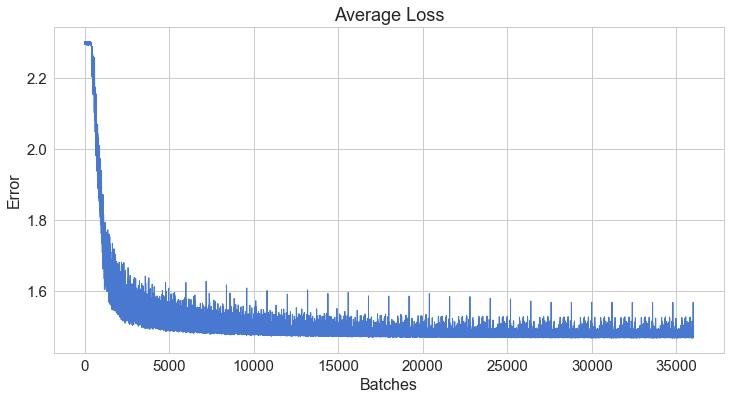

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import numpy as np

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6

plt.xlabel('Batches',fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.title('Average Loss')
plt.grid(True)
plt.plot(range(BATCHES*EPOCHS), loss_datapoints, linewidth=1)
plt.show()

This loss function is the mean of the cross-entropy calculation.  I'm not sure why it appears so cyclical, but considering I observed very similar behavior in the non-TF version of this NN, I think it is either that the model is 'circling' a minimum with a learning rate slightly too high (although I have implemented polynomial decay) or perhaps that I need to add regularization (although I don't know the mechanism by which this could be the cause).